# Notebook settings
This notebook is a universal frame for training a legacy version DistilBERT+Adapted HMCN-F model. It can take in any Parquet dataset with suitable configuration.

This legacy version used a different class indexing algorithm that was not capable of accounting for duplicates across levels. It is the one presented in the paper.

In [1]:
### Dataset configuration
# The parquet folder. It should be located inside datasets/.
DATASET_NAME   = 'Walmart_30k.parquet'
# The input text column
TEXT_COL_NAME  = 'title'
# Which column to use as labelled classes. It should be a column of lists of strings.
CLASS_COL_NAME = 'category'
# How many hierarchical levels to work on. Note that the dataset must also have at least this many levels for every example.
DEPTH = 2 

### Checkpoint configuration
# Whether to train from scratch or to load a checkpoint
TRAIN_FROM_SCRATCH=True
# Checkpoint iteration to load if not training from scratch
LOAD_ITERATION=0
# Last or best results from that iteration?
LOAD_BEST=True

### System configuration
# Will try to use your NVIDIA GPU if one is available. Set to False to force CPU computation
PREFER_GPU         = True
# If you don't have the huggingface transformers library installed, flip this to True.
# You only need to do this once. Once DistilBERT has been downloaded, it will be cached in your system's default user cache folder.
# Once it is cached, please set this to False to avoid redownloads.
INSTALL_DISTILBERT = False

# Import common libraries
And also set up a few things.

In [2]:
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm
import numpy as np
import shutil, sys
from sklearn import metrics
import os

# Set up GPU if available
device = 'cuda' if torch.cuda.is_available() and PREFER_GPU else 'cpu'
print('Using', device)

Using cuda


# Import data

In [3]:
data = pd.read_parquet('../../datasets/{}'.format(DATASET_NAME))
with pd.option_context('display.max_colwidth', None):
    print (data.iloc[0])

title                                                        La Costena Chipotle Peppers, 7 OZ (Pack of 12)
description    La Costena Chipotle Peppers, 7 OZ (Pack of 12) Easy open. Ready to serve! Product of Mexico.
List Price                                                                                            31.93
Sale Price                                                                                            31.93
Brand                                                                                       La Costeï¿½ï¿½a
category                            [Food, Meal Solutions, Grains & Pasta, Canned Goods, Canned Vegetables]
Name: 0, dtype: object


# Categorical-encode the classes
Our implementation of HMCN-F uses ordered global-space indices. That is, in the numerical order will be all classes on the first level, THEN those on the second and so on, with each level's first index starting after the previous level's last index.

The first step to achieving this would be to separate each level into their own column. Then, for categorical encoding to work, the columns themselves must be in Dask's `category` datatype, instead of the default `object` type for non-numerical columns.

Level 0: Index(['Arts Crafts & Sewing', 'Auto & Tires', 'Baby', 'Beauty', 'Books',
       'Cell Phones', 'Character Shop', 'Clothing', 'Collectibles',
       'Electronics', 'Feature', 'Food', 'Health', 'Home', 'Home Improvement',
       'Household Essentials', 'Industrial & Scientific', 'Jewelry', 'Music',
       'Musical Instruments', 'Office Supplies', 'Party & Occasions',
       'Patio & Garden', 'Personal Care', 'Pets', 'Premium Beauty', 'Seasonal',
       'Sports & Outdoors', 'Toys', 'Video Games', 'Walmart for Business'],
      dtype='object')
Level 1: Index(['2-in-1 Hair and Body Care', '@ Manual Shelves - Beauty',
       '@ Manual Shelves - Food', 'ATV & Off-Road', 'Acid Reflux',
       'Action Figures', 'Advance Auto Parts Shop', 'Air Fresheners',
       'All Industrial', 'Allergy and Sinus',
       ...
       'Watches', 'Water Purification', 'Wedding Shop', 'Weight Management',
       'Wellness', 'Wilton Baking Supplies', 'Womens Clothing',
       'Womens Jewelry & Watches', 

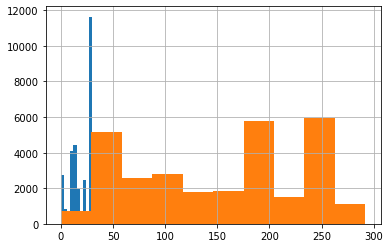

In [4]:
from pandas.api.types import union_categoricals
DEPTH = 2 # From 1.

def split_class_levels(data, class_col_name, depth=2):
  for i in range(depth): 
    data['cls_l{}'.format(i)] = data[class_col_name].apply(
      lambda lst: lst[min(i, len(lst) - 1)]).astype('category')

split_class_levels(data, CLASS_COL_NAME, DEPTH)

# Keep class counts per level
level_class_count = [*map(lambda col_name: data[col_name].cat.codes.nunique(), 
      [*map(lambda i: 'cls_l{}'.format(i), range(DEPTH))]
      )
]

for i in range(DEPTH):
  print('Level {}: {}'.format(i, data['cls_l{}'.format(i)].cat.categories))
  # In preparation of imbalance correction: liist out category populations
  data['cls_l{}'.format(i)].cat.codes.hist()

# Generate a global categorical encoding by stacking the levels
# This ensures that categories from different levels are not mixed together order-wise.
global_categorical = union_categoricals(
    [*map(
        lambda col_name: data[col_name], 
        [*map(lambda i: 'cls_l{}'.format(i), range(DEPTH))]
        )])

idx2cls = global_categorical.categories
print('Global categories:', idx2cls)

# Now build a string-to-index mapping of those categories so we can more easily do one-hots
# and construct the hierarchy later.
cls2idx = dict([(category, index) for (index, category) in enumerate(global_categorical.categories)])
print('Global category codes:', cls2idx)


In [5]:
for i in range(DEPTH):
  print('Level {}: {}'.format(i, len(data['cls_l{}'.format(i)].cat.categories)))

def common(a,b): 
    c = [value for value in a if value in b] 
    return c
common_classes = common(data['cls_l0'].cat.categories, data['cls_l1'].cat.categories)

Level 0: 31
Level 1: 293


At this version we cannot distinguish between classes of the same name but at different levels. As such, we'll simply drop duplicates-in-name from the later levels.

In [6]:
level_class_count[1] -= len(common_classes)

Now we can generate our custom-ordered, global binary encoding.

$|Y_L^h|$ can easily be sliced from the global encoding by relying on the backed-up per-level class counts.

In [7]:
def generate_global_class_binary_encodings(data, class_col_name, cat_dict, depth):
  output_sz = len(cat_dict)
  def runner(cat_lst):
    result = np.zeros(output_sz, dtype=bool)
    result[[*map(lambda name: cat_dict[name], cat_lst[:min(len(cat_lst), depth)])]] = True
    #result[cat_dict[cat_lst[min(len(cat_lst) - 1, depth - 1)]]] = True
    return result
  data['class_global'] = data[class_col_name].apply(runner)

generate_global_class_binary_encodings(data, CLASS_COL_NAME, cls2idx, DEPTH)
data['class_global'][0:10]

0    [False, False, False, False, False, False, Fal...
1    [False, False, False, False, False, False, Fal...
2    [False, False, False, False, False, False, Fal...
3    [False, False, False, False, False, False, Fal...
4    [False, False, True, False, False, False, Fals...
5    [False, False, False, False, False, False, Fal...
6    [False, False, False, False, False, False, Fal...
7    [False, False, False, False, False, False, Fal...
8    [False, False, False, False, False, False, Fal...
9    [False, False, False, False, False, False, Fal...
Name: class_global, dtype: object

We can try recovering category names from this encoding to see if it is still in the original hierarchical order.

In [8]:
def retrieve_classes(encoded, ordered_class_names, verbose=False):
  nonzero_indices = np.nonzero(encoded)
  if verbose:
    print('Nonzero indices:', nonzero_indices)
  return list(ordered_class_names[nonzero_indices])

print('Original:', data.iloc[3]['category'][0:DEPTH])
print('Retrieved:', retrieve_classes(data.iloc[3]['class_global'], global_categorical.categories, verbose=True))

Original: ['Sports & Outdoors' 'Bikes']
Nonzero indices: (array([27, 78]),)
Retrieved: ['Sports & Outdoors', 'Bikes']


# Hierarchy generation
In this model, the hierarchical error penalty is simply $L_H = \lambda \times max(Y_{child} - Y_{parent})$. As such, we need to keep track of each node's parent and vectorise the calculation.

For now I'll be implementing this as simple arrays of class codes (in the global categorical space). We can then use these arrays of codes as vectorised indices to pull out $Y_{parent}$s and have our loss function somewhat vectorised too.

In [9]:
# TODO: Bring the above code into this thing's constructor entirely.
from functools import reduce
class PerLevelHierarchy:
  # level_sizes is a list of (distinct) class counts per hierarchical level.
  #   Its length dictates the maximum hierarchy construction depth.
  #   (that is, our above code)
  # classes is the list of distinct classes, in the order we have assembled.
  def __init__(self, data, level_sizes, classes, class_name2idx):
    self.levels = level_sizes
    # Where each level starts in a global n-hot category vector
    # Its last element is coincidentally the length, which also allows us
    # to simplify the slicing code by blindly doing [offset[i] : offset[i+1]]
    self.level_offsets = reduce(lambda acc, elem: acc + [acc[len(acc) - 1] + elem], level_sizes, [0])
    self.classes = classes
    # Use -1 to indicate 'undiscovered'
    self.parent_of = [-1] * len(self.classes)
    for lst in data['category']:
      # First-level categories' parent is root, but here we set them to themselves.
      # This effectively zeroes out the hierarchical loss for this level.
      self.parent_of[class_name2idx[lst[0]]] = class_name2idx[lst[0]]
      for i in range(1, len(self.levels)):
        child_idx = class_name2idx[lst[i]]
        parent_idx = class_name2idx[lst[i - 1]]
        if self.parent_of[child_idx] == -1:
          self.parent_of[child_idx] = parent_idx

In [10]:
hierarchy = PerLevelHierarchy(data, level_class_count, global_categorical.categories, cls2idx)
hierarchy.parent_of[0:100]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 23,
 3,
 11,
 1,
 12,
 28,
 1,
 15,
 16,
 12,
 13,
 12,
 0,
 28,
 15,
 9,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 3,
 26,
 12,
 7,
 11,
 21,
 13,
 23,
 15,
 14,
 15,
 0,
 3,
 3,
 3,
 3,
 3,
 13,
 12,
 11,
 7,
 27,
 17,
 11,
 30,
 4,
 21,
 9,
 1,
 2,
 12,
 24,
 5,
 4,
 12,
 12,
 11,
 21,
 23,
 26,
 15,
 3,
 11]

# Data and model preparation

## Installing DistilBERT
Alternative to full-fat BERT, roughly matching its performance while being faster.

In [11]:
if not INSTALL_DISTILBERT:
    os.environ['TRANSFORMERS_OFFLINE'] = '1'
else:
    !pip install transformers
    
import transformers as ppb
tokenizer = ppb.DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
base_encoder = ppb.DistilBertModel.from_pretrained('distilbert-base-uncased')
base_encoder_state = base_encoder.state_dict()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Define our dataset adapter class
This wraps around our data and provides a PyTorch-compatible interface.

One point of interest is how we do not explicitly store per-level one-hot encodings. Here we simply store one global copy (n-hot-encoded) then slice from it when requested, saving a bit of memory.

In [12]:
from torch.utils.data import Dataset
import torch

class CustomDataset(Dataset):
  def __init__(self, df, hierarchy, tokenizer, max_len):
    self.tokenizer = tokenizer
    # TODO: Make these customisable from the constructor interface
    self.text = df[TEXT_COL_NAME]
    self.labels = df['class_global']
    self.levels = hierarchy.levels
    self.level_offsets = hierarchy.level_offsets
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, index):
    text = str(self.text.iloc[index])
    text = " ".join(text.split())
    inputs = self.tokenizer(
      text,
      None, # No text_pair
      add_special_tokens=True, # CLS, SEP
      max_length=self.max_len, # For us it's a hyperparam. See next cells.
      padding='max_length',
      truncation=True
      # BERT tokenisers return attention masks by default
    )

    global_labels = self.labels.iloc[index]

    result = {
      'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
      'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
      'global_labels': global_labels,
    }

    return result

Regarding that `max_len` hyperparameter, let's see the distribution of string lengths:

<AxesSubplot:>

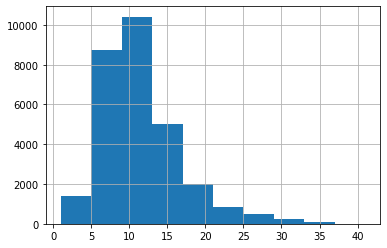

In [13]:
data[TEXT_COL_NAME].apply(lambda s: len(s.split())).hist()

We prefer `max_len` to be a power of two that covers most of the titles. Here it seems 64 will do.

In [14]:
###
### TUNING HYPERPARAMETERS?
### Simply adjust here then run this cell and those below it. No need to run those above.
###

folder_name = 'checkpoints-' + DATASET_NAME
!mkdir $folder_name
CHECKPOINT_IDX = len(os.listdir(folder_name)) // 2
CHECKPOINT_PATH = './{}/{}_current.pt'.format(folder_name, CHECKPOINT_IDX)
BEST_CHECKPOINT_PATH = './{}/{}_best.pt'.format(folder_name, CHECKPOINT_IDX)

# Defining some key variables that will be used later on in the training
MAX_LEN = 64
HIDDEN_SIZE = 384
LINEAR_DROPOUT_RATE = 0.25
TRAIN_BATCH_SIZE = 4
TEST_BATCH_SIZE = 4
EPOCHS = 5
LEARNING_RATE = 1e-03
TRAINING_SET_RATIO = 0.8
VALIDATION_SET_RATIO = 0.1
# The rest is test set
# Don't change this if you want a consistent sampling for easier comparisons
RANDOM_SEED = 123

FULL_SET = True

In [15]:
small_data = None
if not FULL_SET:
    small_data = data.sample(frac = 0.005, random_state=RANDOM_SEED)

CV-split our dataset:

In [16]:
train_set = None
test_set = None
if FULL_SET:
    train_set = data.sample(frac = TRAINING_SET_RATIO, random_state=RANDOM_SEED)
    val_test_set = data.drop(train_set.index)
else:
    train_set = small_data.sample(frac = TRAINING_SET_RATIO, random_state=RANDOM_SEED)
    val_test_set = small_data.drop(train_set.index)

val_set = val_test_set.sample(frac = VALIDATION_SET_RATIO / (1-TRAINING_SET_RATIO), random_state=RANDOM_SEED)
test_set = val_test_set.drop(val_set.index)

train_set = train_set.reset_index(drop=True)
val_set = val_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

(23365, 9)
(2921, 9)
(2920, 9)


We can now wrap them in our Datasets, and then into PyTorch's DataLoaders.

In [17]:
train_set = CustomDataset(train_set, hierarchy, tokenizer, MAX_LEN)
val_set = CustomDataset(val_set, hierarchy, tokenizer, MAX_LEN)
test_set = CustomDataset(test_set, hierarchy, tokenizer, MAX_LEN)

from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset=val_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=test_set, batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=0)

We'll also build a helper to extract per-level labels from the global label vector.

In [18]:
def extract_labels_level(global_labels, hierarchy, level, verbose=False, dims=None):
  if verbose:
    print('Slicing from {} to {}'.format(hierarchy.level_offsets[level], hierarchy.level_offsets[level + 1]))
  if dims is None and global_labels.dim() == 2 or dims == 2:
    return global_labels[:, hierarchy.level_offsets[level] : hierarchy.level_offsets[level + 1]]
  return global_labels[hierarchy.level_offsets[level] : hierarchy.level_offsets[level + 1]]

Test-run:

In [19]:
test_batch = next(iter(test_loader))
print('Retrieved:')
print([retrieve_classes(row, global_categorical.categories) for row in test_batch['global_labels']])
for i in range(DEPTH):
  print('Level {}:'.format(i))
  local_labels = extract_labels_level(test_batch['global_labels'], hierarchy, i, verbose=True)
  nonzero_indices = np.nonzero(local_labels)
  global_nonzero_indices = nonzero_indices[:, 1] + hierarchy.level_offsets[i]
  print('Nonzero indices:', global_nonzero_indices)
  print(global_categorical.categories[global_nonzero_indices])

Retrieved:
[[array(['Sports & Outdoors'], dtype=object), array(['Outdoor Sports'], dtype=object)], [array(['Sports & Outdoors'], dtype=object), array(['Exercise & Fitness'], dtype=object)], [array(['Sports & Outdoors'], dtype=object), array(['Sports'], dtype=object)], [array(['Sports & Outdoors'], dtype=object), array(['Sports'], dtype=object)]]
Level 0:
Slicing from 0 to 31
Nonzero indices: tensor([27, 27, 27, 27])
['Sports & Outdoors' 'Sports & Outdoors' 'Sports & Outdoors'
 'Sports & Outdoors']
Level 1:
Slicing from 31 to 322
Nonzero indices: tensor([220, 126, 281, 281])
['Outdoor Sports' 'Exercise & Fitness' 'Sports' 'Sports']


## Prepare the model itself
Here we use DistilBERT as the encoding layers, followed by our implementation of HMCN-F.

### HMCN-F
HMCN-F is specifically designed for maximizing the learn-
ing capacity regarding the hierarchical structure of the la-
beled data.

In this model, information flows in two ways:
i) the main flow, which begins with the input layer and tra-
verses all fully-connected (FC) layers until it reaches the
global output; and ii) the local flows, which also begin in the
input layer and pass by their respective global FC layers but
also through specific local FC layers, finally ending at the
corresponding local output. For generating the final prediction, all local outputs are then concatenated and pooled with
the global output for a consensual prediction.

Code2paper notation mapping:
- `feature_size` = $|D|$
- `global_hidden_sizes` = list of $|A^i_G|$ for i in $[1, |H|]$
- `local_hidden_sizes` = list of $|A^i_L|$ for i in $[1, |H|]$
- hierarchy:
  - `len(hierarchy.levels)` = $|H|$
  - `len(hierarchy.classes)` = $|C|$
- `global_weight` = $\beta$

**One significant difference between our version and the one in the paper** is that we replace batch normalisation with layer normalisation, which doesn't wreack havoc on NLP tasks like ours.

The FC (linear) layers comprise 384 ReLU
neurons, followed by a batch normalization, residual connections, and dropout of 60%. Dropout is important given
that these models could easily overfit the small training sets.

In [20]:
import torch
from tqdm.notebook import tqdm

class HMCNF(torch.nn.Module):
  def __init__(
      self, 
      feature_size, 
      global_hidden_sizes, 
      local_hidden_sizes, 
      dropout_rate, # after every linear layer
      hierarchy,
      hidden_nonlinear='relu',
      global_weight=0.5
      ):
    super(HMCNF, self).__init__()

    # Back up some parameters for use in forward()
    self.depth = len(hierarchy.levels)
    self.global_weight = global_weight

    # Construct global layers (main flow)
    global_layers = []
    global_layer_norms = []
    for i in range(len(hierarchy.levels)):
      if i == 0:
        global_layers.append(
            torch.nn.Linear(feature_size, global_hidden_sizes[0]))
      else:
        global_layers.append(
            torch.nn.Linear(global_hidden_sizes[i-1] + feature_size, global_hidden_sizes[i]))
      global_layer_norms.append(torch.nn.LayerNorm(global_hidden_sizes[i]))
    self.global_layers = torch.nn.ModuleList(global_layers)
    self.global_layer_norms = torch.nn.ModuleList(global_layer_norms)
    # Global prediction layer
    self.global_prediction_layer = torch.nn.Linear(
        global_hidden_sizes[len(global_hidden_sizes) - 1] + feature_size, 
        len(hierarchy.classes)
        )
    
    # Construct local branches (local flow).
    # Each local branch has two linear layers: a transition layer and a local
    # classification layer 
    transition_layers = []
    local_layer_norms = []
    local_layers = []
    
    for i in range(len(hierarchy.levels)):
      transition_layers.append(
          torch.nn.Linear(global_hidden_sizes[i], local_hidden_sizes[i]),
      )
      local_layer_norms.append(
          torch.nn.LayerNorm(local_hidden_sizes[i])
      )
      local_layers.append(
          torch.nn.Linear(local_hidden_sizes[i], hierarchy.levels[i])
      )
    self.local_layer_norms = torch.nn.ModuleList(local_layer_norms)
    self.transition_layers = torch.nn.ModuleList(transition_layers)
    self.local_layers = torch.nn.ModuleList(local_layers)
    
    # Activation functions
    self.hidden_nonlinear = torch.nn.ReLU() if hidden_nonlinear == 'relu' else torch.nn.Tanh()
    self.output_nonlinear = torch.nn.Sigmoid()

    # Dropout
    self.dropout = torch.nn.Dropout(p=dropout_rate)

  def forward(self, x):
    # We have |D| hidden layers plus one global prediction layer
    local_outputs = []
    output = x # Would be global path output until the last step
    for i in range(len(self.global_layers)):
      # Global path
      if i == 0:
        # Don't concatenate x into the first layer's input
        output = self.hidden_nonlinear(
            self.global_layer_norms[i](
                self.global_layers[i](output)
                )
            )
      else:
        output = self.hidden_nonlinear(self.global_layer_norms[i](
                self.global_layers[i](torch.cat([output, x], dim=1))
              )
            )

      # Local path. Note the dropout between the transition ReLU layer and the local layer.
      local_output = self.dropout(
          self.hidden_nonlinear(
              self.local_layer_norms[i](self.transition_layers[i](output))
              )
            )
      local_output = self.output_nonlinear(self.local_layers[i](local_output))
      local_outputs.append(local_output)

      # Dropout main flow for next layer
      # TODO: investigate introducing layernorm here
      output = self.dropout(output)

    global_outputs = self.output_nonlinear(
      self.global_prediction_layer(torch.cat([output, x], dim=1))
      )
    local_outputs_concat = torch.cat(local_outputs, dim=1)
    output = self.global_weight * global_outputs + (1 - self.global_weight) * local_outputs_concat
    return output, local_outputs

### Entire model

In [21]:
encoder = base_encoder
encoder.load_state_dict(base_encoder_state)
encoder.to(device)

# For now we'll be directly passing to HMCN-F without dropouts. Later we might have to wrap it.
depth = len(hierarchy.levels)
classifier = HMCNF(
  768, # DistilBERT outputs 768 values.
  global_hidden_sizes=[HIDDEN_SIZE] * depth, 
  local_hidden_sizes=[HIDDEN_SIZE] * depth, 
  dropout_rate = LINEAR_DROPOUT_RATE,
  hierarchy=hierarchy,
  hidden_nonlinear='relu',
  global_weight=0.5
)

classifier.to(device)

HMCNF(
  (global_layers): ModuleList(
    (0): Linear(in_features=768, out_features=384, bias=True)
    (1): Linear(in_features=1152, out_features=384, bias=True)
  )
  (global_layer_norms): ModuleList(
    (0): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  )
  (global_prediction_layer): Linear(in_features=1152, out_features=322, bias=True)
  (local_layer_norms): ModuleList(
    (0): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  )
  (transition_layers): ModuleList(
    (0): Linear(in_features=384, out_features=384, bias=True)
    (1): Linear(in_features=384, out_features=384, bias=True)
  )
  (local_layers): ModuleList(
    (0): Linear(in_features=384, out_features=31, bias=True)
    (1): Linear(in_features=384, out_features=291, bias=True)
  )
  (hidden_nonlinear): ReLU()
  (output_nonlinear): Sigmoid()
  (dropout): Dropout(p=0.25, inplace=F

Now we define the loss function that we will use to fine-tune our model (DistilBERT included).

For now we'll stick with one of the provided loss functions instead of building anything radical. As we are performing multiclass classification here, we should use Cross Entropy Loss (the normal one for multiclass, not BCE for binary).

We also construct our optimiser here.



In [22]:
def loss_fn(outputs, targets):
    return torch.nn.BCELoss()(outputs, targets)

# Only train our classifier - leave BERT for later
optimizer = torch.optim.Adam(params=classifier.parameters(), lr=LEARNING_RATE)

## Checkpoints
PyTorch allows us to save the best-performing model automatically so we can restart from that instead of the beginning. No reason not to do that.

In [23]:
import shutil, sys
def load_checkpoint(checkpoint_fpath, model, optimizer=None):
    """
    checkpoint_fpath: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """

    # load check point
    checkpoint = torch.load(checkpoint_fpath)

    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])

    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer'])
        return model, optimizer
    return model

def save_checkpoint(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """

    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model (min validation lost)
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

# Training time

In [24]:
from sklearn import metrics
def get_metrics(local_output, global_output, targets, hierarchy):
    local_leaf_p = local_output[:, hierarchy.level_offsets[DEPTH-1]:]
    global_leaf_p = global_output[:, hierarchy.level_offsets[DEPTH-1]:]
    # Get predicted codes
    local_leaf_codes = np.argmax(local_leaf_p, axis=1) + hierarchy.level_offsets[DEPTH-1]
    global_leaf_codes = np.argmax(global_leaf_p, axis=1) + hierarchy.level_offsets[DEPTH-1]
    # Get target codes
    target_leaf_codes = np.argmax(targets[:, hierarchy.level_offsets[DEPTH-1]:], axis=1) + hierarchy.level_offsets[DEPTH-1]
    
    local_acc = metrics.accuracy_score(local_leaf_codes, target_leaf_codes)
    local_pre = metrics.precision_score(local_leaf_codes, target_leaf_codes, average='weighted')
    print('Local leaf level accuracy:')
    print("Accuracy:", local_acc)
    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:", local_pre)

    global_acc = metrics.accuracy_score(global_leaf_codes, target_leaf_codes)
    global_pre = metrics.precision_score(global_leaf_codes, target_leaf_codes, average='weighted')
    print('\nGlobal leaf level accuracy:')
    print("Accuracy:", global_acc)
    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:", global_pre)
    
    return np.array([local_acc, local_pre, global_acc, global_pre])

In [25]:
from tqdm.notebook import tqdm

def train_model(start_epochs, n_epochs, val_loss_min_input, 
                training_loader, val_loader, model, hierarchy, lambda_factor,
                optimizer, checkpoint_path, best_model_path):
  encoder, classifier = model

  # TODO: Somehow do this on GPU
  parent_of = torch.LongTensor(hierarchy.parent_of)

  # Per-level labels
  level_offsets = reduce(lambda acc, elem: acc + [acc[len(acc) - 1] + elem], hierarchy.levels, [0])

  # Store validation metrics after each epoch
  val_metrics = np.empty((4, 0), dtype=float)

  # Keep min validation (test set) loss so we can separately back up our best-yet model
  val_loss_min = val_loss_min_input
  for epoch in range(start_epochs, n_epochs+1):
    train_loss = 0
    val_loss = 0
    # Put model into training mode. Note that this call DOES NOT train it yet.
    classifier.train()
    print('Epoch {}: Training'.format(epoch))
    for batch_idx, data in enumerate(tqdm(training_loader)):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      global_targets = data['global_labels'].to(device, dtype = torch.float)

      features = encoder(ids, mask)[0][:,0,:]
      global_output, local_outputs = classifier(features)

      optimizer.zero_grad()

      # We have three loss functions: (g)lobal, (l)ocal, and (h)ierarchical.
      loss_g = loss_fn(global_output, global_targets)
      loss_l = sum([ loss_fn(
            local_outputs[level],
            global_targets[:, level_offsets[level] : level_offsets[level + 1]]
            ) for level in range(len(hierarchy.levels))])
      global_output_cpu = global_output.cpu().detach()
      loss_h = torch.sum(lambda_factor * torch.clamp(torch.FloatTensor(
        global_output_cpu - 
        global_output_cpu.index_select(1, parent_of)
      ), min=0) ** 2)
      loss = loss_g + loss_l + loss_h

      # PyTorch defaults to accumulating gradients, but we don't need that here
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss = train_loss + (loss.item() - train_loss) / (batch_idx + 1)

    print('Epoch {}: Testing'.format(epoch))
    
    
    # Switch to evaluation (prediction) mode. Again, this doesn't evaluate anything.
    classifier.eval()

    global_val_targets = np.empty((0, len(hierarchy.classes)), dtype=bool)
    global_val_outputs = np.empty((0, len(hierarchy.classes)), dtype=float)
    local_val_outputs = np.empty((0, len(hierarchy.classes)), dtype=float)

    # We're only testing here, so don't run the backward direction (no_grad).
    with torch.no_grad():
      total_loss_g = 0
      total_loss_l = 0
      total_loss_h = 0
      batch_count = 0
      for batch_idx, data in enumerate(tqdm(val_loader)):
        batch_count += 1
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        global_targets = data['global_labels'].to(device, dtype = torch.float)

        features = encoder(ids, mask)[0][:,0,:]
        global_output, local_outputs = classifier(features)

        loss_g = loss_fn(global_output, global_targets)
        loss_l = sum([ loss_fn(
              local_outputs[level],
              global_targets[:, level_offsets[level] : level_offsets[level + 1]]
              ) for level in range(len(hierarchy.levels))])
        global_output_cpu = global_output.cpu().detach()
        loss_h = torch.sum(lambda_factor * torch.clamp(torch.FloatTensor(
          global_output_cpu - 
          global_output_cpu.index_select(1, parent_of)
        ), min=0) ** 2)
        loss = loss_g + loss_l + loss_h

        total_loss_g += loss_g
        total_loss_l += loss_l
        total_loss_h += loss_h

        val_loss = val_loss + (loss.item() - val_loss) / (batch_idx + 1)

        global_val_targets = np.concatenate([global_val_targets, global_targets.cpu().detach().numpy()])
        global_val_outputs = np.concatenate([global_val_outputs, global_output_cpu.numpy()])
        # Concatenate local test outputs
        local_val_outputs_concat = np.concatenate([*map(lambda t: t.cpu().detach().numpy(), local_outputs)], axis=1)
        local_val_outputs = np.concatenate([local_val_outputs, local_val_outputs_concat])

      # calculate average losses
      #print('before cal avg train loss', train_loss)
      print('Average minibatch global loss:', total_loss_g / batch_count)
      print('Average minibatch local loss:', total_loss_l / batch_count)
      print('Average minibatch hierarchical loss:', total_loss_h / batch_count)
    
      val_metrics = np.concatenate([val_metrics, 
                                    np.expand_dims(get_metrics(local_val_outputs, global_val_outputs, global_val_targets, hierarchy), axis=1)],
                                   axis=1)
      train_loss = train_loss/len(training_loader)
      val_loss = val_loss/len(val_loader)
      # Print training/validation statistics 
      print('Avgerage training loss: {:.6f}\nAverage validation loss: {:.6f}'.format( 
            train_loss,
            val_loss
            ))

      # create checkpoint variable and add important data
      checkpoint = {
            'epoch': epoch + 1,
            'val_loss_min': val_loss,
            'state_dict': classifier.state_dict(),
            'optimizer': optimizer.state_dict()
      }
      # save checkpoint
      save_checkpoint(checkpoint, False, checkpoint_path, best_model_path)

      if val_loss <= val_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min,val_loss))
        # save checkpoint as best model
        save_checkpoint(checkpoint, True, checkpoint_path, best_model_path)
        val_loss_min = val_loss
    print('Epoch {}: Done\n'.format(epoch))
  return classifier, val_metrics

# Alternative: just load from disk
def run_model(model, loader, hierarchy):
  encoder, classifier = model
  # Switch to evaluation (prediction) mode. Again, this doesn't evaluate anything.
  classifier.eval()

  all_global_targets = np.empty((0, len(hierarchy.classes)), dtype=bool)
  all_global_outputs = np.empty((0, len(hierarchy.classes)), dtype=float)
  all_local_outputs = np.empty((0, len(hierarchy.classes)), dtype=float)

  # We're only testing here, so don't run the backward direction (no_grad).
  with torch.no_grad():
    for batch_idx, data in enumerate(tqdm(loader)):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      global_targets = data['global_labels'].to(device, dtype = torch.float)

      features = encoder(ids, mask)[0][:,0,:]
      global_output, local_outputs = classifier(features)

      all_global_targets = np.concatenate([all_global_targets, global_targets.cpu().detach().numpy()])
      all_global_outputs = np.concatenate([all_global_outputs, global_output.cpu().detach().numpy()])
      # Concatenate local test outputs
      local_outputs_concat = np.concatenate([*map(lambda t: t.cpu().detach().numpy(), local_outputs)], axis=1)
      all_local_outputs = np.concatenate([all_local_outputs, local_outputs_concat])
  return {
      'global_targets': all_global_targets,
      'global_outputs': all_global_outputs,
      'local_outputs': all_local_outputs,
  }

Epoch 1: Training


  0%|          | 0/5842 [00:00<?, ?it/s]

Epoch 1: Testing


  0%|          | 0/731 [00:00<?, ?it/s]

Average minibatch global loss: tensor(0.0133, device='cuda:0')
Average minibatch local loss: tensor(0.0598, device='cuda:0')
Average minibatch hierarchical loss: tensor(0.0004)
Local leaf level accuracy:
Accuracy: 0.42930503252310853
Precision: 0.6700589815024754

Global leaf level accuracy:
Accuracy: 0.5203697363916467
Precision: 0.685810834863916
Avgerage training loss: 0.000015
Average validation loss: 0.000101
Validation loss decreased (inf --> 0.000101).  Saving model ...
Epoch 1: Done

Epoch 2: Training


  0%|          | 0/5842 [00:00<?, ?it/s]

Epoch 2: Testing


  0%|          | 0/731 [00:00<?, ?it/s]

Average minibatch global loss: tensor(0.0121, device='cuda:0')
Average minibatch local loss: tensor(0.0524, device='cuda:0')
Average minibatch hierarchical loss: tensor(0.0011)
Local leaf level accuracy:
Accuracy: 0.49777473467990413
Precision: 0.6921654268391583

Global leaf level accuracy:
Accuracy: 0.5453611776788772
Precision: 0.701112479463665
Avgerage training loss: 0.000012
Average validation loss: 0.000090
Validation loss decreased (0.000101 --> 0.000090).  Saving model ...
Epoch 2: Done

Epoch 3: Training


  0%|          | 0/5842 [00:00<?, ?it/s]

Epoch 3: Testing


  0%|          | 0/731 [00:00<?, ?it/s]

Average minibatch global loss: tensor(0.0116, device='cuda:0')
Average minibatch local loss: tensor(0.0524, device='cuda:0')
Average minibatch hierarchical loss: tensor(0.0012)
Local leaf level accuracy:
Accuracy: 0.5207120849024307
Precision: 0.695303293324831

Global leaf level accuracy:
Accuracy: 0.5727490585415953
Precision: 0.7138167765486545
Avgerage training loss: 0.000011
Average validation loss: 0.000089
Validation loss decreased (0.000090 --> 0.000089).  Saving model ...
Epoch 3: Done

Epoch 4: Training


  0%|          | 0/5842 [00:00<?, ?it/s]

Epoch 4: Testing


  0%|          | 0/731 [00:00<?, ?it/s]

Average minibatch global loss: tensor(0.0111, device='cuda:0')
Average minibatch local loss: tensor(0.0503, device='cuda:0')
Average minibatch hierarchical loss: tensor(0.0014)
Local leaf level accuracy:
Accuracy: 0.5566586785347484
Precision: 0.7084164124813814

Global leaf level accuracy:
Accuracy: 0.6039027730229374
Precision: 0.7185599011033112
Avgerage training loss: 0.000010
Average validation loss: 0.000086
Validation loss decreased (0.000089 --> 0.000086).  Saving model ...


/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4: Done

Epoch 5: Training


  0%|          | 0/5842 [00:00<?, ?it/s]

Epoch 5: Testing


  0%|          | 0/731 [00:00<?, ?it/s]

Average minibatch global loss: tensor(0.0107, device='cuda:0')
Average minibatch local loss: tensor(0.0473, device='cuda:0')
Average minibatch hierarchical loss: tensor(0.0018)
Local leaf level accuracy:
Accuracy: 0.578226634714139
Precision: 0.7132729518227438

Global leaf level accuracy:
Accuracy: 0.6158849709003766
Precision: 0.7229154414207053
Avgerage training loss: 0.000010
Average validation loss: 0.000082
Validation loss decreased (0.000086 --> 0.000082).  Saving model ...
Epoch 5: Done



/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


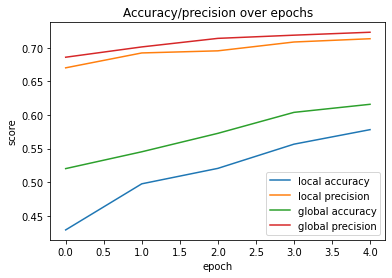

In [27]:
import matplotlib.pyplot as plt

trained_classifier = None
if TRAIN_FROM_SCRATCH:
    trained_classifier, val_metrics = train_model(
        1, # Count from one
        EPOCHS, # EPOCH passes over our training set
        np.Inf, 
        train_loader, 
        val_loader, 
        (encoder, classifier), 
        hierarchy,
        0.05, # Hierarchical loss scaled down to 5%
        optimizer,
        CHECKPOINT_PATH,
        BEST_CHECKPOINT_PATH,
    )
    x = np.arange(EPOCHS)
    fig, ax = plt.subplots()  # Create a figure and an axes.
    ax.plot(x, val_metrics[0], label='local accuracy')
    ax.plot(x, val_metrics[1], label='local precision')
    ax.plot(x, val_metrics[2], label='global accuracy')
    ax.plot(x, val_metrics[3], label='global precision')
    ax.set_xlabel('epoch')  # Add an x-label to the axes.
    ax.set_ylabel('score')  # Add a y-label to the axes.
    ax.set_title("Accuracy/precision over epochs")  # Add a title to the axes.
    ax.legend()  # Add a legend.
    fig.show()
  
else:
    load_path = '{}/{}_{}.pt'.format(folder_name, LOAD_ITERATION, 'best' if LOAD_BEST else 'current')
    trained_classifier = load_checkpoint(load_path, classifier)

In [28]:
test_result = run_model((encoder, trained_classifier), test_loader, hierarchy)

  0%|          | 0/730 [00:00<?, ?it/s]

# Evaluation
We'll mainly use the leaf prediction in real-world applications to ensure 100% hierarchy matches. However, we'll still test with the global encoding just to see what we are getting.

## Transform results
First, transform the leaf predictions into names so we can have a human-readable view of what's going on.

In [29]:
# For now, only do that for leaf
print(test_result['local_outputs'].shape, test_result['global_outputs'].shape)
local_leaf_predictions = test_result['local_outputs'][:, hierarchy.level_offsets[DEPTH-1]:]
global_leaf_predictions = test_result['global_outputs'][:, hierarchy.level_offsets[DEPTH-1]:]
print(local_leaf_predictions.shape, global_leaf_predictions.shape)

(2920, 322) (2920, 322)
(2920, 291) (2920, 291)


In [30]:
# global_test_predictions = [retrieve_classes(row, global_categorical.categories) for row in train_result['global_test_outputs']]

local_leaf_prediction_codes = np.argmax(local_leaf_predictions, axis=1) + hierarchy.level_offsets[DEPTH-1]
global_leaf_prediction_codes = np.argmax(global_leaf_predictions, axis=1) + hierarchy.level_offsets[DEPTH-1]

print(local_leaf_prediction_codes)
print(global_leaf_prediction_codes)

[220 282 279 ... 215 220  64]
[220 282 279 ... 215 220  64]


Let's convert that back to strings for human readability, just to make sure we're doing it right:

In [31]:
local_predicted_leaf_classes = [*map(lambda cat_code: global_categorical.categories[cat_code], local_leaf_prediction_codes)]
global_predicted_leaf_classes = [*map(lambda cat_code: global_categorical.categories[cat_code], global_leaf_prediction_codes)]

Now do the same for the targets:

In [32]:
target_leaf_codes = np.argmax(test_result['global_targets'][:, hierarchy.level_offsets[DEPTH-1]:], axis=1) + hierarchy.level_offsets[DEPTH-1]
print(target_leaf_codes)

target_leaf_classes = global_categorical.categories[target_leaf_codes]

[220 282 150 ... 215 220  64]


Visual match-up:

In [33]:
comp_df = pd.DataFrame({'Locally predicted': local_predicted_leaf_classes, 'Actual': target_leaf_classes, 'Globally predicted': global_predicted_leaf_classes})
comp_df

,Locally predicted,Actual,Globally predicted
0,Outdoor Sports,Outdoor Sports,Outdoor Sports
1,Sports Fan Shop,Sports Fan Shop,Sports Fan Shop
2,"Snacks, Cookies & Chips",Gift Baskets,"Snacks, Cookies & Chips"
3,"Condiments, Sauces & Spices",Breakfast & Cereal,Baking
4,Outdoor Sports,Sports,Ear Care
...,...,...,...
2915,Outdoor Sports,Shop Toys by Age,Outdoor Sports
2916,Vitamins & Supplements,Vitamins & Supplements,Vitamins & Supplements
2917,Oral Care,Oral Care,Oral Care
2918,Outdoor Sports,Outdoor Sports,Outdoor Sports


## Metrics

In [34]:
get_metrics(test_result['local_outputs'], test_result['global_outputs'], test_result['global_targets'], hierarchy)

# Rectified leaf AU(PRC) due to an sklearn bug.
# We add one artificial example that belongs to all classes at once and a corresponding prediction
# full of true positives. This way each class has at least one true positive, even if the test set
# does not contain enough examples to cover all classes.
rectified_outputs = np.concatenate([test_result['global_outputs'][:, hierarchy.level_offsets[-2]:], np.ones((1, hierarchy.levels[-1]))], axis=0)
rectified_targets = np.concatenate([test_result['global_targets'][:, hierarchy.level_offsets[-2]:], np.ones((1, hierarchy.levels[-1]), dtype=bool)], axis=0)

print('\n')
print('Rectified leaf-level AU(PRC) score:', metrics.average_precision_score(rectified_targets, rectified_outputs))

Local leaf level accuracy:
Accuracy: 0.5952054794520548
Precision: 0.7148997738534132

Global leaf level accuracy:
Accuracy: 0.6256849315068493
Precision: 0.7090259868052903




/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rectified leaf-level AU(PRC) score: 0.7588401439163727


# Past results
- `_1`: Equal to `_9` in Walmart_Marketing. However, we now use 10% validation 10% test instead of 20% test.

```
```